In [47]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os


In [2]:
# Setup your PBSCluster

project = 'P93300641' #input your project code
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41401 instead
  f"Port {expected} is already in use.\n"


In [3]:
client.cluster

In [4]:
def get_files(exp):
    d='/glade/scratch/djk2120/PPEn11/amflx_lhc/hist/'+exp+'/*.nc'
    files = sorted(glob.glob(d))
    return files

In [90]:
import operator
def sort_files(exp):

    #get files
    files=get_files(exp)[1:]  #exclude default case
    keys=[f.split('.clm2.')[0][-4:] for f in files]

    #get param values
    pdir='/glade/scratch/djk2120/PPEn11/amflx_lhc/paramfiles/'
    pfiles=[pdir+key+'.nc' for key in keys]
    def preprocess(ds):
        dvs=['kmax','psi50']
        return ds[dvs].isel(segment=0,pft=1)
    ds = xr.open_mfdataset(pfiles,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)
    
    #sort and reshape
    s=[[f,k,p] for f,k,p in zip(files,ds.kmax.values,ds.psi50.values)]
    s.sort(key = operator.itemgetter(1, 2))
    files=np.array([l[0] for l in s])
    nkmax=len(np.unique(ds.kmax))
    np50=len(np.unique(ds.psi50))
    files=files.reshape([nkmax,np50]).tolist()
    kmax=[l[1] for l in s[::np50]]
    p50=[l[2] for l in s[:np50]]

    return files,kmax,p50

In [98]:
def get_ds(exp,dvs=[]):
    files,kmax,p50=sort_files(exp)

    #set up the preprocessing function
    def preprocess(ds,singles=False):
        nt = len(ds.time)
        ix = np.arange(nt)<nt-1 #first timestep is not meaningful
        if singles:
            onecopy  = ['RAIN','SNOW','FSDS','mcsec','TLAI','TBOT','RH']
            ds2 = ds[onecopy].shift(time=-1).isel(time=ix,lndgrid=0)
        else:
            if len(dvs)==0:
                tmp = xr.open_dataset(files[0])
                i=0
                for v in tmp.data_vars:
                    if 'time' in tmp[v].dims:
                        i+=1
                        if i>8:
                            dvs.append(v)
            ds2 = ds[dvs].shift(time=-1).isel(time=ix,lndgrid=0)
        return ds2

    
    #read the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['kmax','p50'],parallel=True,
                           preprocess=preprocess)
    ds0 = preprocess(xr.open_dataset(files[0][0]),singles=True)
    for v in ds0.data_vars:
        ds[v]=ds0[v]
        
    #add params
    ds['kmax']=kmax
    ds['p50']=np.array(p50)/101974
    
    #compute VPD from forcing data
    t=ds.TBOT-273.15
    rh=ds.RH/100
    es=0.61094*np.exp(17.625*t/(t+234.04))
    ds['ESAT']=es
    ds['VPD']=((1-rh)*es).compute()
    ds['VPD'].attrs={'long_name':'vapor pressure deficit','units':'kPa'}

    #provide hour label
    #account for time zone, should double check this
    ndays=int(len(ds.time)/48)
    offset=36
    d=(np.arange(48))/2
    d=[*d[offset:],*d[:offset]]
    x=np.tile(d,ndays)
    ds['hour']=xr.DataArray(x,dims='time')
    


    return ds

### START HERE

In [99]:
%%time
exp='CTL2010SP'
dvs=['FPSN','EFLX_LH_TOT','SOILWATER_10CM','TBOT']
ds1=get_ds(exp,dvs)

CPU times: user 5.42 s, sys: 1.78 s, total: 7.2 s
Wall time: 14.9 s


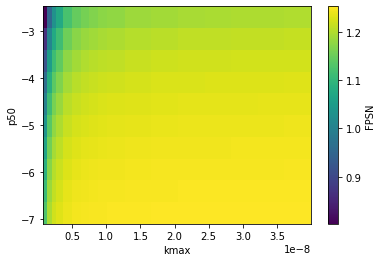

In [100]:
ds1.FPSN.mean(dim='time').plot();

In [12]:
%%time
exp='1.5CSP'
dvs=['FPSN','EFLX_LH_TOT','SOILWATER_10CM','TBOT']
ds2=get_ds(exp,dvs)

CPU times: user 4.97 s, sys: 2.82 s, total: 7.78 s
Wall time: 17.9 s


## 

In [126]:
%%time
exp='80precSP'
dvs=['FPSN','EFLX_LH_TOT','SOILWATER_10CM','VEGWP']
ds2=get_ds(exp,dvs)

CPU times: user 4.46 s, sys: 2.46 s, total: 6.92 s
Wall time: 15.1 s
